# Data Loading: Webdataset

## Overview

This example shows you how to use the data stored in Webdataset format with DALI.

## Using readers.Webdataset operator

Data stored in WebDataset format can be read with `readers.Webdataset` operator. The operator takes the following arguments:

* `paths` the path (or list of paths) to the tar archives containing webdataset
* `index_paths` the path (or list of paths) to the respective index files containing data about the specifics of the tar files, created using `wds2idx` - a utility included with DALI. For the usage details please refer to `wds2idx -h`. If not provided, it will be automatically inferred from the tar file, although it will take considerable time for big datasets.
* `ext`  the extension set (or list of those) of extensions separated by a ';' that specify the outputs of the operator and which sample components will be fed into the specific outputs of the operator
* `missing_component_behavior` the behavior of the reader in case it encounters a sample that can't return provide any component to a certain output. There are 3 options:
    * `empty` (default) returns an empty tensor for that output
    * `skip` the samples with missing components are skipped
    * `error` an error is raised
* `dtypes` the data types of the outputs of the operator. If the size of the output component is not divisible by the size of the type, an error is raised. If not provided, data is returned as UINT8.
In addition to these arguments, the operator accepts arguments common to all readers, which configure the seed of random number generator, shuffling, sharding and handling of incomplete batches at the end of epoch.

## Creating an index
The index file(s), paths to which are passed in the argument index_paths , can be generated with a tool wds2idx, bundled with DALI.

**Note**: The `DALI_EXTRA_PATH` environment variable should point to the location where data from [DALI extra repository](https://github.com/NVIDIA/DALI_extra) is downloaded.

**Important**: Ensure that you check out the correct release tag that corresponds to the installed version of DALI.

In [1]:
import os
from pathlib import Path

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

import nvidia.dali.experimental.dynamic as ndd

dali_extra_dir = Path(os.environ["DALI_EXTRA_PATH"])
wds_root = dali_extra_dir / "db" / "webdataset"
wds_tar = wds_root / "train.tar"
wds_idx = wds_root / "train.idx"
batch_size = 16

## Reading and Processing Images

1. Read the images stored in Webdataset format and decode them.

   In this example we process images by cropping, normalizing, and `HWC` -> `CHW` conversion process.

In [2]:
reader = ndd.readers.Webdataset(
    paths=wds_tar,
    index_paths=wds_idx,
    ext=["jpg", "cls"],
    missing_component_behavior="error",
)

for img_raw, cls in reader.next_epoch(batch_size=batch_size):
    images = ndd.decoders.image(img_raw, device="gpu")
    resized = ndd.resize(images, resize_shorter=256.0)
    output = ndd.crop_mirror_normalize(
        resized,
        dtype=ndd.float32,
        crop=(224, 224),
        mean=[0.0, 0.0, 0.0],
        std=[1.0, 1.0, 1.0],
    )
    break  # Run once

2. To visualize the results, use the `matplotlib` library, which expects images in `HWC` format, but the output is in `CHW`.
3. For the visualization purposes, transpose the images back to the `HWC` layout.

In [3]:
def show_images(image_batch: ndd.Batch, label_batch: ndd.Batch):
    columns = 4
    rows = (batch_size + 1) // columns
    fig = plt.figure(figsize=(20, (20 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j, (img, label) in enumerate(zip(image_batch, label_batch)):
        plt.subplot(gs[j])
        plt.axis("off")
        ascii_data = np.asarray(label)
        plt.title(
            "".join([chr(item) for item in ascii_data]),
            fontdict={"fontsize": 25},
        )
        img_chw = np.asarray(img.cpu())
        img_hwc = np.transpose(img_chw, (1, 2, 0)) / 255.0
        plt.imshow(img_hwc)
    plt.show()

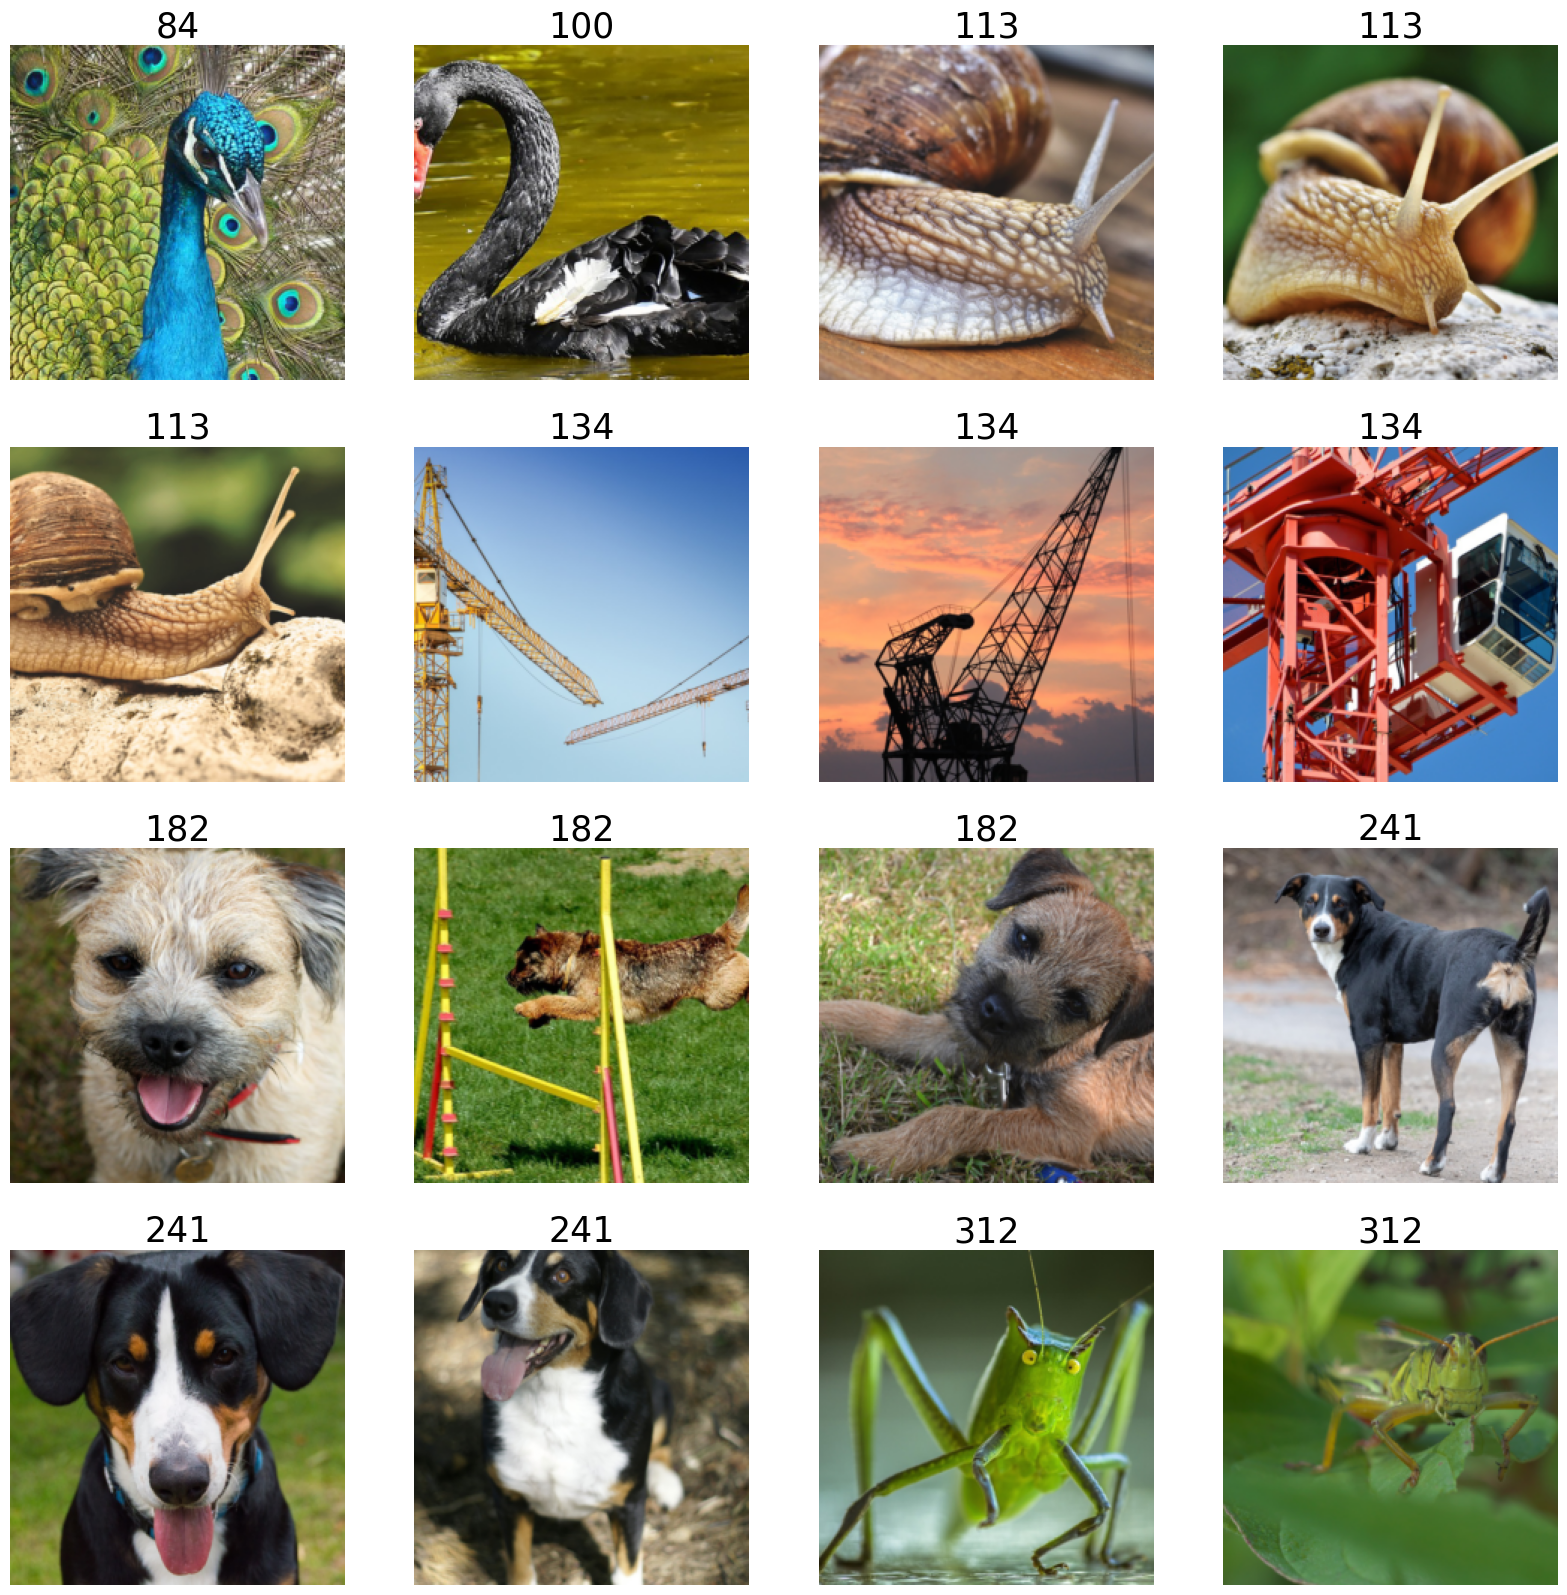

In [4]:
show_images(output, cls)